# Multi-Class Image Classification Deep Learning Model for Textile Defect Detection Using TensorFlow Take 1
### David Lowe
### March 25, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Textile Defect Detection dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: This dataset from Kaggle contains 96,000 patches of the textile image with different quality problems. The goal of the exercise is to detect the quality issue for a patch of textile during production. The greyscale photos are part of the public dataset made available by the MVTec Company and referred by the research paper from Paul Bergmann, Michael Fauser, David Sattlegger, Carsten Steger. MVTec AD - A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection; in: IEEE Conference on Computer Vision and Pattern Recognition (CVPR), June 2019.

In this Take1 iteration, we will construct a CNN model using a simple three-block VGG architecture and test the model's performance using a separate test dataset.

ANALYSIS: In this Take1 iteration, the baseline model's performance achieved an accuracy score of 97.07% on the validation dataset after 15 epochs. Furthermore, the final model's performance achieved an accuracy score of 68.03% on the test dataset after 15 epochs.

CONCLUSION: In this iteration, the simple three-block VGG CNN model did not appear suitable for modeling this dataset due to a high-variance problem. We should consider experimenting with more or different data for further modeling.

Dataset Used: Textile Defect Detection

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: https://www.kaggle.com/belkhirnacim/textiledefectdetection

Potential source of performance benchmarks: https://www.kaggle.com/belkhirnacim/textiledefectdetection

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Mar 17 20:40:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 8

In [6]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import zipfile
from datetime import datetime
import h5py
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.25

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=seedNum)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCH = 15
BATCH_SIZE = 64
RAW_IMAGE_SIZE = (64, 64)
TARGET_IMAGE_SIZE = (64, 64)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 1)

NUM_CLASSES = 6
CLASS_LABELS = ['0','1','2','3','4','5']
CLASS_NAMES = ['good','color','cut','hole','thread','metal_contamination']

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
TRAIN_DIR = 'staging/'
# VALID_DIR = 'staging/'
TEST_DIR = 'staging/'
TRAIN_DATASET = 'train64.h5'
# VALID_DATASET = ''
TEST_DATASET = 'test64.h5'
TRAIN_LABELS = 'train64.csv'
# VALID_LABELS = ''
TEST_LABELS = 'test64.csv'
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.4.1


In [8]:
# Set up the parent directory location for loading the dotenv files
# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [11]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [13]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [14]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/

In [15]:
STAGING_DIR = 'staging/'
!mkdir staging/

In [16]:
!wget -P staging/ https://dainesanalytics.com/datasets/kaggle-textile-defect-detection/train64.csv
!wget -P staging/ https://dainesanalytics.com/datasets/kaggle-textile-defect-detection/train64.h5

--2021-03-17 20:40:24--  https://dainesanalytics.com/datasets/kaggle-textile-defect-detection/train64.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.220.81, 13.227.220.111, 13.227.220.12, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.220.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1204015 (1.1M) [text/csv]
Saving to: ‘staging/train64.csv’

train64.csv         100%[===================>]   1.15M  --.-KB/s    in 0.04s   

2021-03-17 20:40:24 (31.1 MB/s) - ‘staging/train64.csv’ saved [1204015/1204015]

--2021-03-17 20:40:24--  https://dainesanalytics.com/datasets/kaggle-textile-defect-detection/train64.h5
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.220.81, 13.227.220.111, 13.227.220.12, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.220.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 786434048 (750M) [application/x-www-form-urlencoded]
Saving to: ‘stag

In [17]:
images_original_hf = h5py.File(TRAIN_DIR+TRAIN_DATASET, 'r')
print(images_original_hf.keys())
images_original = np.array(images_original_hf['images'])
images_original_hf.close()
print(images_original.shape)

<KeysViewHDF5 ['images']>
(48000, 64, 64, 1)


In [18]:
dataset_path = TRAIN_DIR + TRAIN_LABELS
labels_original_csv = pd.read_csv(dataset_path)
labels_original = labels_original_csv['indication_value'].ravel()
print('Label array shape before encoding:', labels_original.shape)

class_encoder = preprocessing.LabelBinarizer()
labels_original = class_encoder.fit_transform(labels_original)
print('Label array shape after encoding:', labels_original.shape)

Label array shape before encoding: (48000,)
Label array shape after encoding: (48000, 6)


In [19]:
# Split the data further into training and test datasets
images_train, images_valid, labels_train, labels_valid = train_test_split(images_original, labels_original, test_size=VAL_SET_SIZE, stratify=labels_original, random_state=seedNum)
print("images_train.shape: {} labels_train.shape: {}".format(images_train.shape, labels_train.shape))
print("images_valid.shape: {} labels_valid.shape: {}".format(images_valid.shape, labels_valid.shape))

images_train.shape: (36000, 64, 64, 1) labels_train.shape: (36000, 6)
images_valid.shape: (12000, 64, 64, 1) labels_valid.shape: (12000, 6)


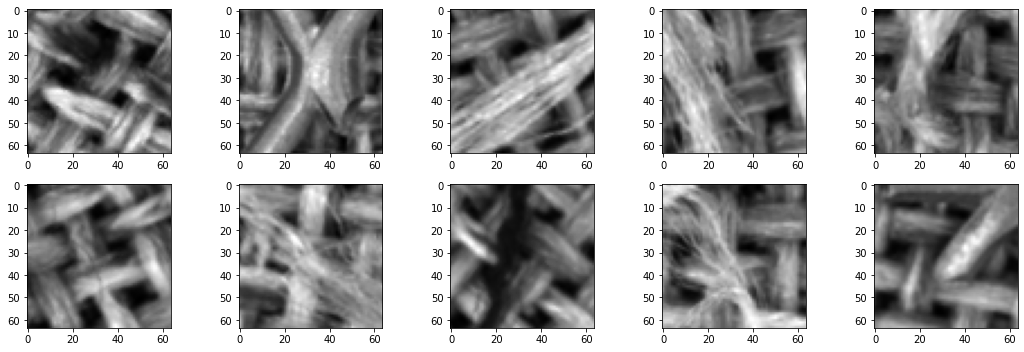

In [20]:
# Spot-checking the first 10 training images
f, ax = plt.subplots(2, 5)
f.set_size_inches(15, 5)
k = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(images_train[k].reshape(RAW_IMAGE_SIZE), cmap="gray")
        k += 1
plt.tight_layout()
plt.show()

In [21]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [22]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [23]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == train_loss:
#             plt.ylim([0, plt.ylim()[1]])
#         else:
#             plt.ylim([0.5, 1.1])
        plt.legend()

In [24]:
def create_nn_model(conv1_filters=128, conv2_filters=256, conv3_filters=512, conv1_dropout=0.25, conv2_dropout=0.25, conv3_dropout=0.25,
                    input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param, input_shape=input_param),
        keras.layers.Conv2D(conv1_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D((2,2), strides=2),
        keras.layers.Dropout(conv1_dropout),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv2_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D((2,2), strides=2),
        keras.layers.Dropout(conv2_dropout),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv3_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv3_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv3_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D((2,2), strides=2),
        keras.layers.Dropout(conv3_dropout),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        keras.layers.Dense(output_param, activation=classifier_activation)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [25]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.000001)
reset_random(seedNum)
baseline_model = create_nn_model()
baseline_model_history = baseline_model.fit(
    images_train, labels_train,
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCH,
	validation_data=(images_valid, labels_valid),
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
563/563 [==============================] - 39s 58ms/step - loss: 3.0414 - accuracy: 0.3696 - val_loss: 1.0127 - val_accuracy: 0.5872
Epoch 2/15
563/563 [==============================] - 31s 56ms/step - loss: 0.9381 - accuracy: 0.6248 - val_loss: 0.5832 - val_accuracy: 0.7772
Epoch 3/15
563/563 [==============================] - 31s 55ms/step - loss: 0.6053 - accuracy: 0.7650 - val_loss: 0.4927 - val_accuracy: 0.8122
Epoch 4/15
563/563 [==============================] - 31s 55ms/step - loss: 0.4392 - accuracy: 0.8288 - val_loss: 0.4357 - val_accuracy: 0.8360
Epoch 5/15
563/563 [==============================] - 31s 56ms/step - loss: 0.3077 - accuracy: 0.8824 - val_loss: 0.2741 - val_accuracy: 0.8994
Epoch 6/15
563/563 [==============================] - 31s 55ms/step - loss: 0.2247 - accuracy: 0.9178 - val_loss: 0.2323 - val_accuracy: 0.9210
Epoch 7/15
563/563 [==============================] - 31s 56ms/step - loss: 0.1722 - accuracy: 0.9407 - val_loss: 0.1548 - val_accuracy:

In [26]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0

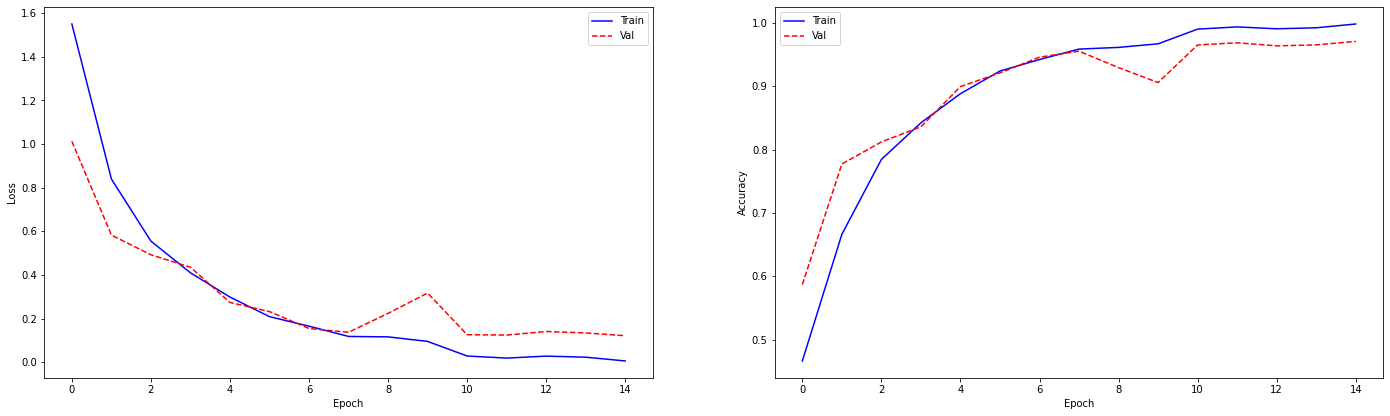

In [27]:
plot_metrics(baseline_model_history)

In [28]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [29]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [30]:
# Not applicable for this iteration of modeling

In [31]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [32]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [33]:
!wget -P staging/ https://dainesanalytics.com/datasets/kaggle-textile-defect-detection/test64.csv
!wget -P staging/ https://dainesanalytics.com/datasets/kaggle-textile-defect-detection/test64.h5

--2021-03-17 20:48:44--  https://dainesanalytics.com/datasets/kaggle-textile-defect-detection/test64.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 99.86.202.73, 99.86.202.11, 99.86.202.61, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|99.86.202.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1144993 (1.1M) [text/csv]
Saving to: ‘staging/test64.csv’

test64.csv          100%[===================>]   1.09M   798KB/s    in 1.4s    

2021-03-17 20:48:47 (798 KB/s) - ‘staging/test64.csv’ saved [1144993/1144993]

--2021-03-17 20:48:47--  https://dainesanalytics.com/datasets/kaggle-textile-defect-detection/test64.h5
Resolving dainesanalytics.com (dainesanalytics.com)... 99.86.202.73, 99.86.202.11, 99.86.202.61, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|99.86.202.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 786434048 (750M) [application/x-www-form-urlencoded]
Saving to: ‘staging/test64.h5’


In [34]:
images_test_hf = h5py.File(TEST_DIR+TEST_DATASET, 'r')
print(images_test_hf.keys())
images_test = np.array(images_test_hf['images'])
images_test_hf.close()
print(images_test.shape)

<KeysViewHDF5 ['images']>
(48000, 64, 64, 1)


In [35]:
dataset_path = TEST_DIR + TEST_LABELS
labels_test_csv = pd.read_csv(dataset_path)
labels_test = labels_test_csv['indication_value'].ravel()
print('Label array shape before encoding:', labels_test.shape)

labels_test = class_encoder.transform(labels_test)
print('Label array shape after encoding:', labels_test.shape)

Label array shape before encoding: (48000,)
Label array shape after encoding: (48000, 6)


In [36]:
final_LR = 0.00025
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=final_LR)
reset_random(seedNum)
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(images_original, labels_original, batch_size=BATCH_SIZE, epochs=MAX_EPOCH, verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
750/750 [==============================] - 38s 50ms/step - loss: 2.4764 - accuracy: 0.3945
Epoch 2/15
750/750 [==============================] - 37s 50ms/step - loss: 0.7527 - accuracy: 0.7063
Epoch 3/15
750/750 [==============================] - 37s 50ms/step - loss: 0.4537 - accuracy: 0.8242
Epoch 4/15
750/750 [==============================] - 38s 50ms/step - loss: 0.3136 - accuracy: 0.8799
Epoch 5/15
750/750 [==============================] - 38s 51ms/step - loss: 0.1957 - accuracy: 0.9282
Epoch 6/15
750/750 [==============================] - 38s 50ms/step - loss: 0.1229 - accuracy: 0.9575
Epoch 7/15
750/750 [==============================] - 38s 50ms/step - loss: 0.1024 - accuracy: 0.9645
Epoch 8/15
750/750 [==============================] - 38s 50ms/step - loss: 0.0726 - accuracy: 0.9747
Epoch 9/15
750/750 [==============================] - 38s 50ms/step - loss: 0.0504 - accuracy: 0.9823
Epoch 10/15
750/750 [==============================] - 38s 50ms/step - loss: 0.052

In [37]:
# Display a summary of the final model
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 128)       1280      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 256)      

In [38]:
final_model.evaluate(images_test, labels_test, batch_size=BATCH_SIZE, verbose=1)

750/750 [==============================] - 13s 18ms/step - loss: 2.6677 - accuracy: 0.6803


[2.6677348613739014, 0.6802916526794434]

In [39]:
test_pred = final_model.predict(images_test)
test_predictions = np.argmax(test_pred, axis=-1)
labels_test = class_encoder.inverse_transform(labels_test)
print('Accuracy Score:', accuracy_score(labels_test, test_predictions))
print(confusion_matrix(labels_test, test_predictions))
print(classification_report(labels_test, test_predictions))

Accuracy Score: 0.6802916666666666
[[7548   43  170   69  146   24]
 [ 266 7341  124  159   48   62]
 [1099   47 4646 1651  416  141]
 [ 618   19 5034 1823  462   44]
 [ 340  243 2291 1108 3825  193]
 [  80    3   71  124  251 7471]]
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      8000
           1       0.95      0.92      0.94      8000
           2       0.38      0.58      0.46      8000
           3       0.37      0.23      0.28      8000
           4       0.74      0.48      0.58      8000
           5       0.94      0.93      0.94      8000

    accuracy                           0.68     48000
   macro avg       0.69      0.68      0.67     48000
weighted avg       0.69      0.68      0.67     48000



In [40]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [41]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:19:26.938087
